In [1]:
import os
import sys
import datetime
import string
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NAME = 'Amsgrad_main_dataset' # helps to differentiate between various training instances

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchtext.data import Field, BucketIterator, TabularDataset

sys.path.append(os.path.abspath(os.path.join('..')))

from models.las_model.data import SpeechDataset, AudioDataLoader
from models.las_model.listener import Listener
from models.las_model.attend_and_spell import AttendAndSpell
from models.las_model.seq2seq import Seq2Seq
# from models.las_model.utils import  train

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

GeForce GTX 1080 Ti
Tesla P100-PCIE-16GB
Tesla P100-PCIE-16GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-16GB


In [3]:
DEVICE = torch.device('cuda:6') if torch.cuda.is_available() else 'cpu'
print('DEVICE :', DEVICE)

DEVICE : cuda:6


### Preprocessing

In [4]:
data_dir = '../../../Dataset/Sinhala'

remove_chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
                 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', \
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',  'x', 'y', 'z', \
                '“', '”', '\u200b', '\u200c', '\u200d', 'µ', '\x94', '»', 'ª', '’', '‘']


def preprocess(s):
    s = s.replace('\n', '')  # remove '\n'
    return s.translate(str.maketrans('', '', string.punctuation)) # remove punctuation


# reading the main transcript
lines = []
with open(os.path.join(data_dir, 'utt_spk_text.tsv'), 'r', encoding='utf-8') as f:
    lines = f.readlines()

examples = []
for l in lines:
    append = True
    id_, _, sent = l.split('\t')
    sent = preprocess(sent)
    for c in sent:
        if c in remove_chars:  # removing sentences with eng_chars
            append = False
            break
    if append:
        examples.append((id_+'.flac', sent))

data_df = pd.DataFrame(examples, columns=['path', 'sent'])
data_df.to_csv(os.path.join(data_dir, 'data_df.csv')) # save
print("Number of Training examples:", data_df.shape[0])
data_df.head(5)

Number of Training examples: 149569


,path,sent
0,0000f47c22.flac,මහවැලි ගඟට ගොස් ආපසු එන ගමනේදී
1,000101700f.flac,උන්වහන්සේ කපාපු
2,000107b539.flac,එය එතනින් අවසන් නොවී
3,00016825d3.flac,සිතින් අයහපතෙහි හැසිරීම නිසයි
4,0002205a57.flac,ඊට අවසරයද හිමිවූ බව ඇය කියන්නීය


We have tried removing all the unnecessary characters from the dataset. The others will be replaced by unknown token, while training.

### Load data

In [5]:
from sklearn.model_selection import train_test_split

data_df = pd.read_csv(os.path.join(data_dir, 'data_df.csv'), usecols=['path', 'sent'])
train_df, val_df = train_test_split(data_df, test_size=0.01)
print("Num training example:", train_df.shape)
print("Num validation example", val_df.shape)
train_df.head()

Num training example: (148073, 2)
Num validation example (1496, 2)


,path,sent
33658,39ebbfdc10.flac,එවැනි පුද්ගලයන් අනුන්ගේ
17274,1da510f7af.flac,එතකොට එයාට තේරෙනවා
122419,d1ce802e86.flac,ඉඩම් මංකොල්ල කන්න හදනවා කියලා
47748,524194097a.flac,ඒවා අනාගත පරපුරට
135318,e79e200f8e.flac,ඹබ මෙම ස්ථානයට සංචාරයේ යෙදෙන්නට බලාපොරොත්තු වේ


### Vocabulary

In [6]:
chars = ['<pad>', '<unk>', '<sos>', '<eos>', 'ම', 'ෙ', ' ', 'ක', 'ැ', 'ස',\
         '්', 'බ', 'ෑ', 'ව', 'ා', 'ො', 'ර', 'ි', 'ී', 'න', 'ධ', 'ග', 'ේ',\
         'ය', 'හ', 'උ', 'ු', 'ද', 'ට', 'ල', 'අ', 'ප', 'ණ', 'ඳ', 'ත', 'ළ', 'ඩ',\
         'එ', 'ං', 'ෝ', 'ඔ', 'ඹ', 'ඇ', 'ආ', 'ඉ', 'ජ', 'ඟ', 'භ', 'ඕ', 'ශ', \
         'ූ', 'ෂ', 'ඝ', 'ෞ', 'ඒ', 'ඬ', 'ච', 'ථ', 'ඨ', 'ඊ', 'ඤ', 'ඈ', 'ඡ', \
         'ෆ', 'ඵ', 'ඛ', 'ඌ', 'ඓ', 'ෛ', 'ඪ']

char_to_token = {c:i for i,c in enumerate(chars)} 
token_to_char = {i:c for c,i in char_to_token.items()}

sos_token = char_to_token['<sos>']
eos_token = char_to_token['<eos>']
pad_token = char_to_token['<pad>']
unk_token = char_to_token['<unk>']

print("Number of characters:", len(chars))

Number of characters: 70


### Instantiate model

In [7]:
input_size = 128    # num rows in instagram
hidden_dim = 640  # 256*2 nodes in each LSTM
num_layers = 4
dropout = 0.1
layer_norm = False   
encoder = Listener(input_size, hidden_dim, num_layers, dropout=dropout, layer_norm=layer_norm)

hid_sz = 640
vocab_size = len(chars)
decoder = AttendAndSpell(hid_sz, encoder.output_size, vocab_size)

hyperparams = {'input_size':input_size, 'hidden_dim':hidden_dim, 
               'num_layers':num_layers,'dropout':dropout, 
               'layer_norm':layer_norm, 'hid_sz':hid_sz, 
               'vocab_size':vocab_size}

model = Seq2Seq(encoder, decoder, tf_ratio = 1.0, device=DEVICE).to(DEVICE)
model.train()

Seq2Seq(
  (encoder): Listener(
    (layers): ModuleList(
      (0): piBLSTM(
        (lstm): LSTM(128, 640, batch_first=True, bidirectional=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
      (1): piBLSTM(
        (lstm): LSTM(2560, 640, batch_first=True, bidirectional=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
      (2): piBLSTM(
        (lstm): LSTM(2560, 640, batch_first=True, bidirectional=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
      (3): piBLSTM(
        (lstm): LSTM(2560, 640, batch_first=True, bidirectional=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): AttendAndSpell(
    (attention_layer): Attention(
      (linear1): Linear(in_features=3200, out_features=1600, bias=True)
      (linear2): Linear(in_features=1600, out_features=1, bias=True)
    )
    (pre_lstm_cell): LSTMCell(2630, 640)
    (post_lstm_cell): LSTMCell(3200, 640)
    (mlp): Sequential(
      (0): Linear(in_features=640, out_features=7

### Training

In [8]:
# model.load_state_dict(torch.load(os.path.join(save_dir, 'las_model_1')))
# model.train()

# load = False
# if load:
#     saved_file = 'Trained Models/Training_2019-12-25 00:09:23.921978/las_model_6'
#     model.load_state_dict(torch.load(saved_file))
#     start_epoch = int(saved_file[-1]) + 1
#     time = os.listdir(tensorboard_dir)[-1]  # use the last one 

time = str(datetime.datetime.now())
save_dir = os.path.join('trained_models', f'{NAME}_{time}')
try:    
    os.mkdir(save_dir);
except FileExistsError:
    pass

# Saving hyperparmas
with open(os.path.join(save_dir, 'info.pickle'), 'wb') as f:
    pickle.dump(hyperparams, f)

In [14]:
def train(model, device, train_loader, optimizer, epoch, 
          print_interval, writer=None, log_interval=-1, scheduler=None, train_dataset=None):
    
    model.train()
    print(f'Training, Logging: Mean loss of previous {print_interval} batches \n')
    
    running_loss = []
    date1 = datetime.datetime.now()
    

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        loss, _ = model(data, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.detach().item())    # update running loss

        # writing to console after print_interval batches
        if (batch_idx+1) % print_interval == 0:
            date2 = datetime.datetime.now()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tMean Loss : {:.6f}\t lr {}\t time {}:'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                np.mean(running_loss[-print_interval:]), 
                optimizer.state_dict()['param_groups'][0]['lr'],
                date2 - date1))
            date1 = date2

        # Writing to tensorboard
        if (batch_idx+1) % log_interval == 0:
            if writer:
                global_step = epoch * len(train_loader) + batch_idx
                writer.add_scalar('Loss', np.mean(running_loss[-log_interval:]), global_step)

        if batch_idx == len(train_loader)//2:
            # save, # check, 
            torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_half_{epoch}'))
            torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optim_half_{epoch}'))
            validate_personal(model, 2, train_dataset)

#       if scheduler:
#                 if batch_idx == len(train_loader)//2:
#                     # save, # check, # decrease lr
#                     torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_half_{epoch}'))
#                     torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optim_half_{epoch}'))
#                     validate_personal(model, 2, train_dataset)
#                     for param_group in optimizer.param_groups:
#                         param_group['lr'] = max(param_group['lr']*0.5, 0.001)
#                     print("-"*10, "LR decreased", '-'*10)
#                     model.train()
                
    
def decode_pred_sent(out):
    pred_sent = []
    out = out.squeeze(0)
    for t in out:
        lol = t.max(dim=0)[1].item()
        pred_sent.append(token_to_char[lol])
    return ''.join(pred_sent)


def decode_true_sent(y):
    sent = []
    for t in y:
        sent.append(token_to_char[t.item()])
    return ''.join(sent)

def validate_personal(model, num_sent, dataset, show=False):
    model.eval()
    for _ in range(num_sent):
        idx = random.randint(0, dataset.__len__())

        x, y = dataset.__getitem__(idx)
        plt.imshow(x[0,:,:].detach().log2())
        if show:
            plt.show()
        else:
            plt.close()
        target = y.unsqueeze(dim=0).to(DEVICE)
        data = x.permute(0, 2, 1).to(DEVICE)
        loss, output = model(data, target)
        print("\n")
        print("True sent : ", decode_true_sent(y))
        print("Pred sent : ", decode_pred_sent(output))
        print("Loss :", loss.item())  
    model.train()

torch.Size([1, 128, 294])
torch.Size([1, 128, 338])
torch.Size([1, 128, 269])
torch.Size([1, 128, 263])
torch.Size([1, 128, 401])
torch.Size([1, 128, 176])
torch.Size([1, 128, 338])
torch.Size([1, 128, 163])
torch.Size([1, 128, 263])
torch.Size([1, 128, 263])


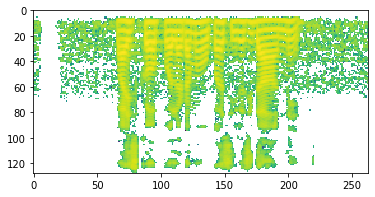

In [10]:
# checking the width
train_dataset = SpeechDataset(train_df, data_dir, char_to_token, n_fft=1024, hop_length=256)
train_loader = AudioDataLoader(pad_token, train_dataset, batch_size=64, 
                               shuffle=True, drop_last=True, num_workers=8)
for i in range(10):
    idx = random.randint(0, train_dataset.__len__())
    x, y = train_dataset.__getitem__(idx)
    print(x.shape)
plt.imshow(x[0,:,:].detach().log2())

In [13]:
# optimizer = optim.SGD(model.parameters(), lr=0.2)  # lr = 0.2 used in paper
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True, cooldown=5, min_lr=0.00001)

#optimizer = optim.Adam(model.parameters(), amsgrad=True)

# optimizer = optim.Adadelta(model.parameters())
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, )

# hence approximately waiting for print_interval*batch_size*(patience+cooldown) to improve
log_interval = 5
print_interval = 50

epochs = 20
load = False

writer = SummaryWriter(save_dir)
print('save_dir', save_dir)



# load_dict = 'trained_models/Adadelta_NC_step_1_2019-12-31 04:30:30.395730'
# model.load_state_dict(torch.load(os.path.join(load_dict, 'las_model_half_0')))
# optimizer.load_state_dict(torch.load(os.path.join(load_dict, 'optim_half_0')))


for epoch in range(1, epochs): 
    train(model, DEVICE, train_loader, optimizer, epoch, print_interval, writer, 
          log_interval, scheduler=True, train_dataset=train_dataset)
    
    #save model
    torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_{epoch}'))
    torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optim_{epoch}'))
    
    validate_personal(model, 2, train_dataset)
    
    # Decrease tf_ratio
#     if (epoch+1)%10 == 0:
#         model.tf_ratio = model.tf_ratio - 0.5
#         print("\nTeacher forcing ratio:", model.tf_ratio)
    
#     if scheduler:
#         validate_personal(model, 2, train_dataset)
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = max(param_group['lr']*0.1, 0.001)
#         print("-"*10, "LR decreased", '-'*10)

save_dir trained_models/Amsgrad_main_dataset_2019-12-31 09:04:26.359994
Training, Logging: Mean loss of previous 50 batches 



True sent :  පෙබරවාරි මාර්තු වස්තු ලාබ මෙන්ම ආදායම් තත්ත්වය ද උසස් වෙයි<eos>
Pred sent :  ඌ පිිි ිවකි ි ිවකිව ිවකි වකිනි  කවව    කිි ි ා කිකනිි කින  
Loss : 4.16019868850708


True sent :  සාරා විසින් යම් උපායක් යොදනවා<eos>
Pred sent :  ඌ වි කිතිවව කි  කනි  ි කිවව ා 
Loss : 4.030393600463867
Train Epoch: 0 [76736/148073 (52%)]	Mean Loss : 3.881571	 lr 0.001	 time 0:02:21.420132:
Train Epoch: 0 [79936/148073 (54%)]	Mean Loss : 3.868470	 lr 0.001	 time 0:00:47.351637:
Train Epoch: 0 [83136/148073 (56%)]	Mean Loss : 3.870795	 lr 0.001	 time 0:00:51.084461:
Train Epoch: 0 [86336/148073 (58%)]	Mean Loss : 3.860556	 lr 0.001	 time 0:00:50.312840:
Train Epoch: 0 [89536/148073 (60%)]	Mean Loss : 3.853164	 lr 0.001	 time 0:00:52.450526:
Train Epoch: 0 [92736/148073 (63%)]	Mean Loss : 3.834124	 lr 0.001	 time 0:00:49.243519:
Train Epoch: 0 [95936/148073 (65%)]	Mean Loss

KeyboardInterrupt: 

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.2)  # lr = 0.2 used in paper
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True, cooldown=5, min_lr=0.00001)

#optimizer = optim.Adam(model.parameters(), amsgrad=True)

# optimizer = optim.Adadelta(model.parameters())
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, )

# hence approximately waiting for print_interval*batch_size*(patience+cooldown) to improve
log_interval = 5
print_interval = 50

epochs = 20
load = False

writer = SummaryWriter(save_dir)
print('save_dir', save_dir)



# load_dict = 'trained_models/Adadelta_NC_step_1_2019-12-31 04:30:30.395730'
# model.load_state_dict(torch.load(os.path.join(load_dict, 'las_model_half_0')))
# optimizer.load_state_dict(torch.load(os.path.join(load_dict, 'optim_half_0')))


for epoch in range(1, epochs): 
    train(model, DEVICE, train_loader, optimizer, epoch, print_interval, writer, 
          log_interval, scheduler=True, train_dataset=train_dataset)
    
    #save model
    torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_{epoch}'))
    torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optim_{epoch}'))
    
    validate_personal(model, 2, train_dataset)
    
    # Decrease tf_ratio
#     if (epoch+1)%10 == 0:
#         model.tf_ratio = model.tf_ratio - 0.5
#         print("\nTeacher forcing ratio:", model.tf_ratio)
    
#     if scheduler:
#         validate_personal(model, 2, train_dataset)
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = max(param_group['lr']*0.1, 0.001)
#         print("-"*10, "LR decreased", '-'*10)

save_dir trained_models/Amsgrad_main_dataset_2019-12-31 09:04:26.359994
Training, Logging: Mean loss of previous 50 batches 



### TEST

In [ ]:
def decode_pred_sent(out):
    pred_sent = []
    out = out.squeeze(0)
    for t in out:
        lol = t.max(dim=0)[1].item()
        pred_sent.append(token_to_char[lol])
    return ''.join(pred_sent)


def decode_true_sent(y):
    sent = []
    for t in y:
        sent.append(token_to_char[t.item()])
    return ''.join(sent)

In [ ]:
num_sent = 10
model.eval()

for _ in range(num_sent):
    
    idx = random.randint(0, train_df.shape[0])
    trial_dataset = SpeechDataset(train_df, data_dir, char_to_token)

    x, y = trial_dataset.__getitem__(idx)
    # plt.imshow(x[0,:,:].detach())

    # Model output
    print(y.shape)
    
    target = y.unsqueeze(dim=0).to(DEVICE)
    data = x.permute(0, 2, 1).to(DEVICE)
    loss, output = model(data, target)
    print(output.shape)
    print("True sent : ", decode_true_sent(y), end='\n\n')
    print("Pred sent : ", decode_pred_sent(output))
    print("Loss :", loss.item())    
    print("\n")

### Trying with Torchtext

In [ ]:
## Knowing the frequency of words

def process(s):
    return list(s)

si_field = Field(
    tokenizer_language='si',
    lower=True, 
    init_token='<sos>', 
    eos_token='<eos>',
    batch_first=True,
    preprocessing=process
)

dataset = TabularDataset(
    path=os.path.join(data_dir, 'temp.csv'),
    format='CSV',
    fields=[('index', None),('unnamed', None), ('sent', si_field)]
)

In [ ]:
si_field.build_vocab(dataset, min_freq=2)
print(len(si_field.vocab.stoi))